In [2]:
import scipy.signal
import pandas as pd
from scipy.signal import savgol_filter

def vel_filter(ang_vel_all):
    b, a = scipy.signal.butter(2, 0.1, 'lowpass')
    # b, a = scipy.signal.butter(5, 0.05, 'lowpass')
    # b, a = scipy.signal.butter(N=5, Wn=33, fs=200, btype='lowpass', analog=False)
    return scipy.signal.filtfilt(b, a, ang_vel_all)

# Data structure to organize pair conditions
cam_velocities_per_motion_condition_given_obj_vel  = {
    "with_faster": {
        15.0: 22.5,
        30.0: 45.0,
        60.0: 90.0,
    },
    "with_same": {
        15.0: 15.0,
        30.0: 30.0,
        60.0: 60.0,
    },
    "with_half": {
        15.0: 7.5,
        30.0: 15.0,
        60.0: 30.0,
    },
    "zero": {
        15.0: 0,
        30.0: 0,
        60.0: 0,
    },
    "against_half": {
        15.0: -7.5,
        30.0: -15.0,
        60.0: -30.0,
    }
}

object_velocities = [
    15.0,
    30.0, 
    60.0, 
]

object_directions = {
    "horizontal_left": (-1, 0),
    "horizontal_right": (1, 0), 
    "vertical_up": (0, 1),
    "vertical_down": (0, -1),
}

import numpy as np
import matplotlib.pyplot as plt

# Map TrialID to camera motion type and object speed based on an external mapping file
def map_camera_motion_type_and_object_speed(data_df, trial_details_df):
    data_df = data_df.merge(trial_details_df[['trial_id', 'camera_motion_type', 'object_speed', 'camera_speed', 'object_motion_type']],
                            left_on='TrialID', right_on='trial_id', how='left')
    return data_df
# Apply the filter to each trial individually
def apply_filter_per_trial(df, column_name, new_column_name):
    df[new_column_name] = (
        df.groupby('TrialNumber')[column_name]
        .transform(lambda x: vel_filter(x.fillna(0)))
    )
    return df

def compute_position_dependent_angular_error(df, screen_width, screen_height, screen_diagonal_size, distance_to_screen):
    # Convert screen diagonal size to pixels
    diagonal_resolution = np.sqrt(screen_width**2 + screen_height**2)
    pixel_size = diagonal_resolution / screen_diagonal_size  # Pixels per inch
    distance_to_screen_pixels = distance_to_screen * pixel_size * 39.37  # Convert meters to inches

    # Compute screen center
    screen_center_x = screen_width / 2
    screen_center_y = screen_height / 2

    # Compute distances
    df['PixelDistance'] = np.sqrt((df['FilteredPogX'] - df['BallX'])**2 + (df['FilteredPogY'] - df['BallY'])**2)
    df['TargetToCenterDistance'] = np.sqrt((df['BallX'] - screen_center_x)**2 + (df['BallY'] - screen_center_y)**2)

    # Adjust distance to screen based on target's position on screen
    df['DistanceToScreenAdjusted'] = np.sqrt(distance_to_screen_pixels**2 + df['TargetToCenterDistance']**2)

    # Compute angular error
    df['AngularError'] = np.degrees(np.arctan(df['PixelDistance'] / df['DistanceToScreenAdjusted']))
    
    return df
def find_first_within_angular_threshold(df, angular_threshold, time_threshold):
    # Filter rows to only consider those after the time threshold
    df['WithinThreshold'] = (df['AngularError'] <= angular_threshold) & (df['RelativeTime'] > time_threshold)

    # Find the first index where the condition is met for each trial
    df['FirstWithinThreshold'] = df.groupby('TrialNumber')['WithinThreshold'].transform(
        lambda x: x.idxmax() if x.any() else np.nan
    )
    return df

def discard_trials_with_high_angular_error(df, angular_error_threshold):
    """
    Discards trials where any row in the trial has an angular error exceeding the threshold
    or where the angular error exceeds the threshold in the first 0.5 seconds of the trial.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing angular error and trial information.
        angular_error_threshold (float): The threshold for angular error. Trials with errors exceeding this value will be removed.

    Returns:
        pd.DataFrame: Filtered DataFrame with trials exceeding the angular error threshold removed.
    """
    # Identify trials where any angular error exceeds the threshold
    trials_to_discard_high_error = df[df['AngularError'] > angular_error_threshold]['TrialNumber'].unique()

    # Identify trials where the angular error exceeds the threshold in the first 0.5 seconds
    # trials_to_discard_initial_error = df[(df['RelativeTime'] <= 0.0001) & (df['AngularError'] > 10)]['TrialNumber'].unique()

    # Combine the two sets of trials to discard
    trials_to_discard = np.unique(np.concatenate((trials_to_discard_high_error, [])))

    print(trials_to_discard)
    # Filter out rows from these trials
    filtered_df = df[~df['TrialNumber'].isin(trials_to_discard)]

    return filtered_df
# Screen resolution
screen_width = 2560
screen_height = 1440

In [ ]:
def get_matching_trials(condition, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, obj_speed, cam_speed):
    matching_trials = {'horizontal_left': [], 'horizontal_right': []}
    for _, trial in trial_details_df.iterrows():
        object_motion = trial['object_motion_type']
        
        # Check if the trial matches the object velocity and corresponding camera velocity
        expected_cam_speed = cam_velocities_per_motion_condition_given_obj_vel[condition].get(obj_speed)
        if expected_cam_speed is not None and trial['object_speed'] == obj_speed and trial['camera_speed'] == expected_cam_speed:
            for direction in matching_trials.keys():
                if object_motion == direction:
                    matching_trials[direction].append(trial['trial_id'])
    return matching_trials

def find_first_within_angular_threshold(df, angular_threshold, time_threshold):
    # Filter rows to only consider those after the time threshold
    df['WithinThreshold'] = (df['AngularError'] <= angular_threshold) & (df['RelativeTime'] > time_threshold)

    # Find the first index where the condition is met for each trial
    df['FirstWithinThreshold'] = df.groupby('TrialNumber')['WithinThreshold'].transform(
        lambda x: x.idxmax() if x.any() else np.nan
    )
    return df

def plot_condition_speed_pairs_with_threshold(
    df, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, angular_threshold, 
    time_passed_seconds, alpha=0.6, filter_obj_speeds=None
):
    # Colors for different directions
    direction_colors = {'horizontal_left': 'blue', 'horizontal_right': 'red'}

    # Get unique object speeds and apply filtering if specified
    obj_speeds = sorted(trial_details_df['object_speed'].unique())
    if filter_obj_speeds is not None:
        obj_speeds = [speed for speed in obj_speeds if speed in filter_obj_speeds]

    # Identify valid conditions
    valid_conditions = cam_velocities_per_motion_condition_given_obj_vel.keys()

    # Create a figure with subplots for valid conditions
    num_conditions = len(valid_conditions)
    num_rows = (num_conditions + 1) // 2  # Determine rows needed for 2 columns
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, 5 * num_rows), sharex=False, sharey=True)
    axes = axes.flatten()  # Flatten for easy indexing

    for idx, condition in enumerate(valid_conditions):
        ax = axes[idx]  # Get the subplot for this condition

        total_trials = 0
        points_found = 0
        max_relative_time = 0  # To track the max relative time for plotted data

        for obj_speed in obj_speeds:
            cam_speed = cam_velocities_per_motion_condition_given_obj_vel[condition].get(obj_speed, None)
            if cam_speed is None:
                continue

            # Get matching trial IDs for all directions based on the condition and speeds
            matching_trials = get_matching_trials(
                condition, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, obj_speed, cam_speed
            )

            # Check if there are any matching trials; skip if none
            if not any(matching_trials.values()):
                continue

            # Plot trials for each direction in the same subplot
            for direction, trial_ids in matching_trials.items():
                color = direction_colors[direction]  # Set color based on direction
                for trial_id in trial_ids:
                    total_trials += 1  # Increment the total trial count
                    # Filter data for the current trial ID and make a copy
                    trial_data = df[df['TrialID'] == trial_id].copy()

                    # Update max relative time for plotted data
                    max_relative_time = max(max_relative_time, trial_data['RelativeTime'].max())

                    # Flip X positions only for horizontal left direction
                    if direction == 'horizontal_left':
                        trial_data['FilteredPogX'] = -trial_data['FilteredPogX'] + screen_width
                        trial_data['BallX'] = -trial_data['BallX'] + screen_width

                    # Plot each individual trial in the direction
                    for trial_num in trial_data['TrialNumber'].unique():
                        single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]
                        ax.plot(
                            single_trial_data['RelativeTime'],
                            single_trial_data['FilteredPogX'],
                            color=color,
                            label=f"{direction.replace('_', ' ').title()}"
                            if trial_num == trial_data['TrialNumber'].unique()[0]
                            else "",
                            alpha=alpha,
                        )

                        # Plot the absolute object position X as black dashed lines
                        ax.plot(
                            single_trial_data['RelativeTime'],
                            single_trial_data['BallX'],
                            color='black',
                            linestyle='--',
                        )

                        # Plot the first point within the angular threshold
                        first_index = single_trial_data['FirstWithinThreshold'].iloc[0]
                        if not np.isnan(first_index):
                            points_found += 1  # Increment points found count
                            first_point = single_trial_data.loc[first_index]
                            ax.plot(
                                first_point['RelativeTime'],
                                first_point['FilteredPogX'],
                                'o',
                                color='orange',
                            )

        # Add the counts to the subplot title
        ax.set_title(
            f"Condition: {condition}\nPoints Found: {points_found}",
            fontsize=14,
        )
        ax.set_xlabel("Relative Time (s)")
        ax.set_ylabel("Mapped X Position (pixels)")

        # Set x-axis limits based on the max relative time of plotted data
        ax.set_xlim(0, max_relative_time)
        ax.set_ylim(750, screen_width)
        # ax.legend()

    # Hide unused subplots
    for idx in range(len(valid_conditions), len(axes)):
        axes[idx].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()



# Example usage with a specific object velocity filter for horizontal directions
filter_obj_speeds = [
    15.0, 
    30.0, 
    60.0
    ]  # Specify the object speeds to include in the plots

# Preprocess data to find points within angular threshold
angular_threshold = 2.0  # Degrees
time_passed_seconds = 0.15
data = find_first_within_angular_threshold(data, angular_threshold, time_passed_seconds)

for obj_speed in filter_obj_speeds:
    # Plot pairs with markers for the first point within threshold and filtered object speeds
    plot_condition_speed_pairs_with_threshold(
        data, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, 
        angular_threshold, time_passed_seconds, alpha=0.3, filter_obj_speeds=[obj_speed]
    )


In [ ]:
def get_matching_trials(condition, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, obj_speed, cam_speed):
    matching_trials = {'vertical_down': []}
    for _, trial in trial_details_df.iterrows():
        object_motion = trial['object_motion_type']
        camera_motion = trial['camera_motion_type']
        
        # Check if the trial matches the object velocity and corresponding camera velocity
        expected_cam_speed = cam_velocities_per_motion_condition_given_obj_vel[condition].get(obj_speed)
        if expected_cam_speed is not None and trial['object_speed'] == obj_speed and trial['camera_speed'] == expected_cam_speed:
            for direction in matching_trials.keys():
                if object_motion == direction:
                    matching_trials[direction].append(trial['trial_id'])
    return matching_trials

def plot_condition_speed_pairs_with_threshold(
    df, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, angular_threshold, 
    time_passed_seconds, alpha=0.6, filter_obj_speeds=None
):
    # Colors for different directions
    direction_colors = {'vertical_down': 'green'}

    # Get unique object speeds and apply filtering if specified
    obj_speeds = sorted(trial_details_df['object_speed'].unique())
    if filter_obj_speeds is not None:
        obj_speeds = [speed for speed in obj_speeds if speed in filter_obj_speeds]

    # Identify valid conditions
    valid_conditions = cam_velocities_per_motion_condition_given_obj_vel.keys()

    # Create a figure with subplots for valid conditions
    num_conditions = len(valid_conditions)
    num_rows = (num_conditions + 1) // 2  # Determine rows needed for 2 columns
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, 5 * num_rows), sharex=False, sharey=True)
    axes = axes.flatten()  # Flatten for easy indexing

    for idx, condition in enumerate(valid_conditions):
        ax = axes[idx]  # Get the subplot for this condition

        total_trials = 0
        points_found = 0
        max_relative_time = 0  # To track the max relative time for plotted data

        for obj_speed in obj_speeds:
            cam_speed = cam_velocities_per_motion_condition_given_obj_vel[condition].get(obj_speed, None)
            if cam_speed is None:
                continue

            # Get matching trial IDs for all directions based on the condition and speeds
            matching_trials = get_matching_trials(
                condition, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, obj_speed, cam_speed
            )

            # Check if there are any matching trials; skip if none
            if not any(matching_trials.values()):
                continue
                        
            # Plot trials for each direction in the same subplot
            for direction, trial_ids in matching_trials.items():
                color = direction_colors[direction]  # Set color based on direction
                for trial_id in trial_ids:
                    total_trials += 1  # Increment the total trial count
                    # Filter data for the current trial ID and make a copy
                    trial_data = df[df['TrialID'] == trial_id].copy()

                    max_relative_time = max(max_relative_time, trial_data['RelativeTime'].max())

                    # Plot each individual trial in the direction
                    for trial_num in trial_data['TrialNumber'].unique():
                        single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]
                        ax.plot(
                            single_trial_data['RelativeTime'],
                            single_trial_data['FilteredPogY'],
                            color=color,
                            label=f"{direction.replace('_', ' ').title()}"
                            if trial_num == trial_data['TrialNumber'].unique()[0]
                            else "",
                            alpha=alpha,
                        )

                        # Plot the absolute object position X as black dashed lines
                        ax.plot(
                            single_trial_data['RelativeTime'],
                            single_trial_data['BallY'],
                            color='black',
                            linestyle='--',
                        )

                        # Plot the first point within the angular threshold
                        first_index = single_trial_data['FirstWithinThreshold'].iloc[0]
                        if not np.isnan(first_index):
                            points_found += 1  # Increment points found count
                            first_point = single_trial_data.loc[first_index]
                            ax.plot(
                                first_point['RelativeTime'],
                                first_point['FilteredPogY'],
                                'o',
                                color='orange',
                            )

        # Add the counts to the subplot title
        ax.set_title(
            f"Condition: {condition}\nPoints Found: {points_found}",
            fontsize=14,
        )
        ax.set_xlabel("Relative Time (s)")
        ax.set_ylabel("Mapped Y Position (pixels)")
        ax.set_xlim(0, max_relative_time)
        ax.set_ylim(-600, 800)
        ax.legend()

    # Hide unused subplots
    for idx in range(len(valid_conditions), len(axes)):
        axes[idx].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


filter_obj_speeds = [
    15.0,
    30.0,
    60.0
]  

# Preprocess data to find points within angular threshold
angular_threshold = 2.0  # Degrees
time_passed_seconds = 0.15
data = find_first_within_angular_threshold(data, angular_threshold, time_passed_seconds)

for obj_speed in filter_obj_speeds:
    # Plot pairs with markers for the first point within threshold and filtered object speeds
    plot_condition_speed_pairs_with_threshold(
        data, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, 
        angular_threshold, time_passed_seconds, alpha=0.3, filter_obj_speeds=[obj_speed]
    )


In [ ]:
def get_matching_trials(condition, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, obj_speed, cam_speed):
    matching_trials = {'vertical_up': []}
    for _, trial in trial_details_df.iterrows():
        object_motion = trial['object_motion_type']
        camera_motion = trial['camera_motion_type']
        
        # Check if the trial matches the object velocity and corresponding camera velocity
        expected_cam_speed = cam_velocities_per_motion_condition_given_obj_vel[condition].get(obj_speed)
        if expected_cam_speed is not None and trial['object_speed'] == obj_speed and trial['camera_speed'] == expected_cam_speed:
            for direction in matching_trials.keys():
                if object_motion == direction:
                    matching_trials[direction].append(trial['trial_id'])
    return matching_trials

def plot_condition_speed_pairs_with_threshold(
    df, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, angular_threshold, 
    time_passed_seconds, alpha=0.6, filter_obj_speeds=None
):
    # Colors for different directions
    direction_colors = {'vertical_up': 'orange'}

    # Get unique object speeds and apply filtering if specified
    obj_speeds = sorted(trial_details_df['object_speed'].unique())
    if filter_obj_speeds is not None:
        obj_speeds = [speed for speed in obj_speeds if speed in filter_obj_speeds]

    # Identify valid conditions
    valid_conditions = cam_velocities_per_motion_condition_given_obj_vel.keys()

    # Create a figure with subplots for valid conditions
    num_conditions = len(valid_conditions)
    num_rows = (num_conditions + 1) // 2  # Determine rows needed for 2 columns
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, 5 * num_rows), sharex=False, sharey=True)
    axes = axes.flatten()  # Flatten for easy indexing

    for idx, condition in enumerate(valid_conditions):
        ax = axes[idx]  # Get the subplot for this condition

        total_trials = 0
        points_found = 0
        max_relative_time = 0  # To track the max relative time for plotted data

        for obj_speed in obj_speeds:
            cam_speed = cam_velocities_per_motion_condition_given_obj_vel[condition].get(obj_speed, None)
            if cam_speed is None:
                continue

            # Get matching trial IDs for all directions based on the condition and speeds
            matching_trials = get_matching_trials(
                condition, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, obj_speed, cam_speed
            )

            # Check if there are any matching trials; skip if none
            if not any(matching_trials.values()):
                continue
                        
            # Plot trials for each direction in the same subplot
            for direction, trial_ids in matching_trials.items():
                color = direction_colors[direction]  # Set color based on direction
                for trial_id in trial_ids:
                    total_trials += 1  # Increment the total trial count
                    # Filter data for the current trial ID and make a copy
                    trial_data = df[df['TrialID'] == trial_id].copy()

                    max_relative_time = max(max_relative_time, trial_data['RelativeTime'].max())

                    # # Flip X positions only for horizontal left direction
                    # if direction == 'vertical_up':
                    #     trial_data['FilteredPogY'] = -trial_data['FilteredPogY'] + screen_width
                    #     trial_data['BallY'] = -trial_data['BallY'] + screen_width

                    # Plot each individual trial in the direction
                    for trial_num in trial_data['TrialNumber'].unique():
                        single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]
                        ax.plot(
                            single_trial_data['RelativeTime'],
                            single_trial_data['FilteredPogY'],
                            color=color,
                            label=f"{direction.replace('_', ' ').title()}"
                            if trial_num == trial_data['TrialNumber'].unique()[0]
                            else "",
                            alpha=alpha,
                        )

                        # Plot the absolute object position X as black dashed lines
                        ax.plot(
                            single_trial_data['RelativeTime'],
                            single_trial_data['BallY'],
                            color='black',
                            linestyle='--',
                        )

                        # Plot the first point within the angular threshold
                        first_index = single_trial_data['FirstWithinThreshold'].iloc[0]
                        if not np.isnan(first_index):
                            points_found += 1  # Increment points found count
                            first_point = single_trial_data.loc[first_index]
                            ax.plot(
                                first_point['RelativeTime'],
                                first_point['FilteredPogY'],
                                'o',
                                color='orange',
                            )

        # Add the counts to the subplot title
        ax.set_title(
            f"Condition: {condition}\nPoints Found: {points_found}",
            fontsize=14,
        )
        ax.set_xlabel("Relative Time (s)")
        ax.set_ylabel("Mapped Y Position (pixels)")
        ax.set_xlim(0, max_relative_time)
        ax.set_ylim(-0, screen_height)
        ax.legend()

    # Hide unused subplots
    for idx in range(len(valid_conditions), len(axes)):
        axes[idx].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


filter_obj_speeds = [
    15.0,
    30.0,
    60.0
]  

# Preprocess data to find points within angular threshold
angular_threshold = 2.0  # Degrees
time_passed_seconds = 0.15
data = find_first_within_angular_threshold(data, angular_threshold, time_passed_seconds)

for obj_speed in filter_obj_speeds:
    # Plot pairs with markers for the first point within threshold and filtered object speeds
    plot_condition_speed_pairs_with_threshold(
        data, cam_velocities_per_motion_condition_given_obj_vel, trial_details_df, 
        angular_threshold, time_passed_seconds, alpha=0.3, filter_obj_speeds=[obj_speed]
    )


bingxuan
[  26.   27.  138.  157.  202.  801.  817. 1011. 1219.]


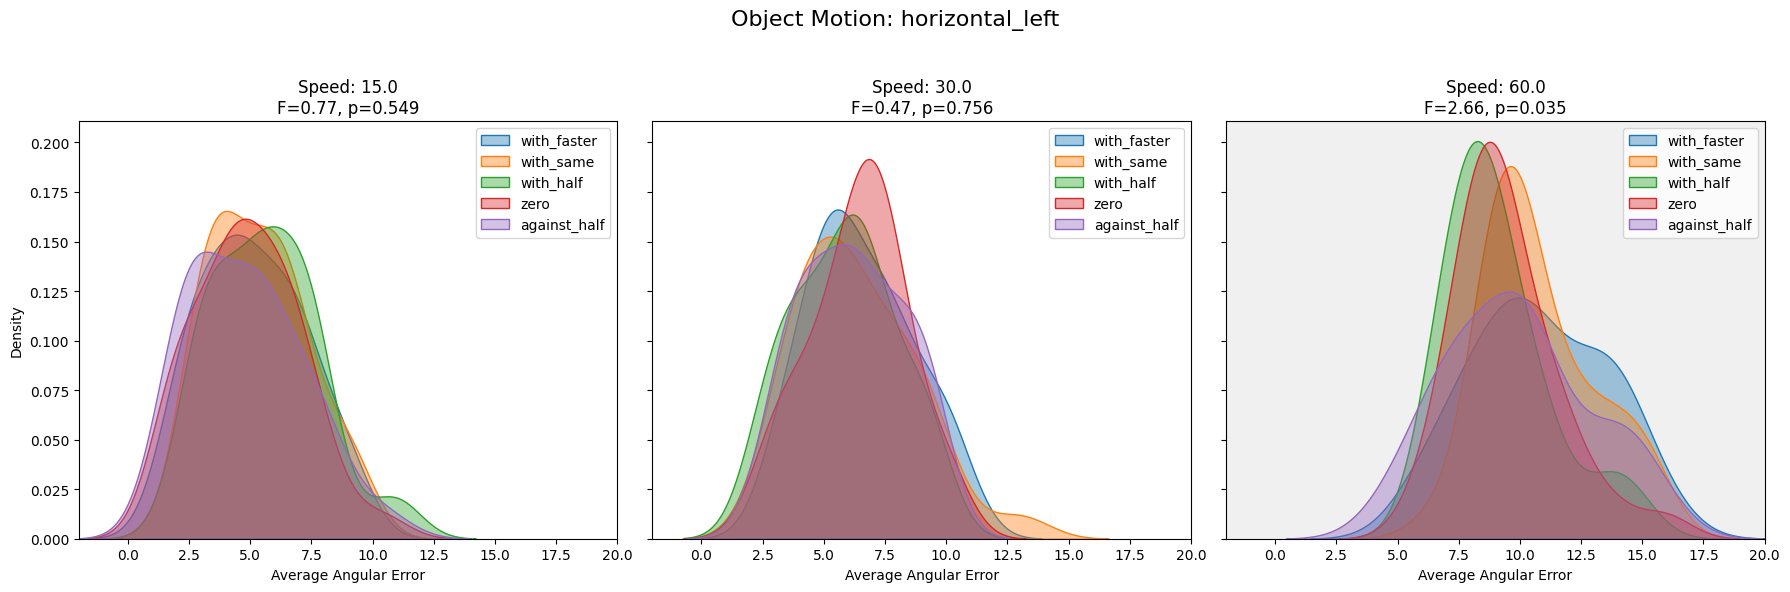

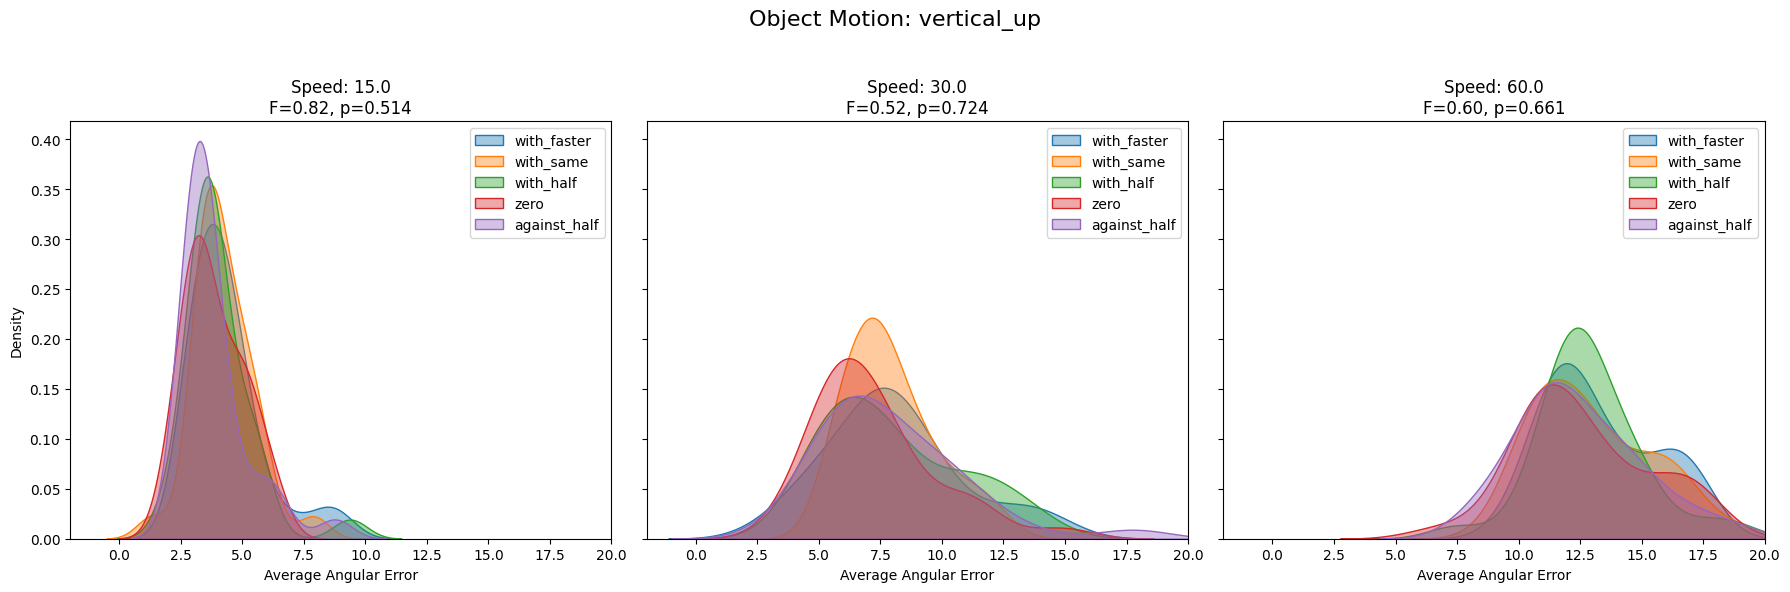

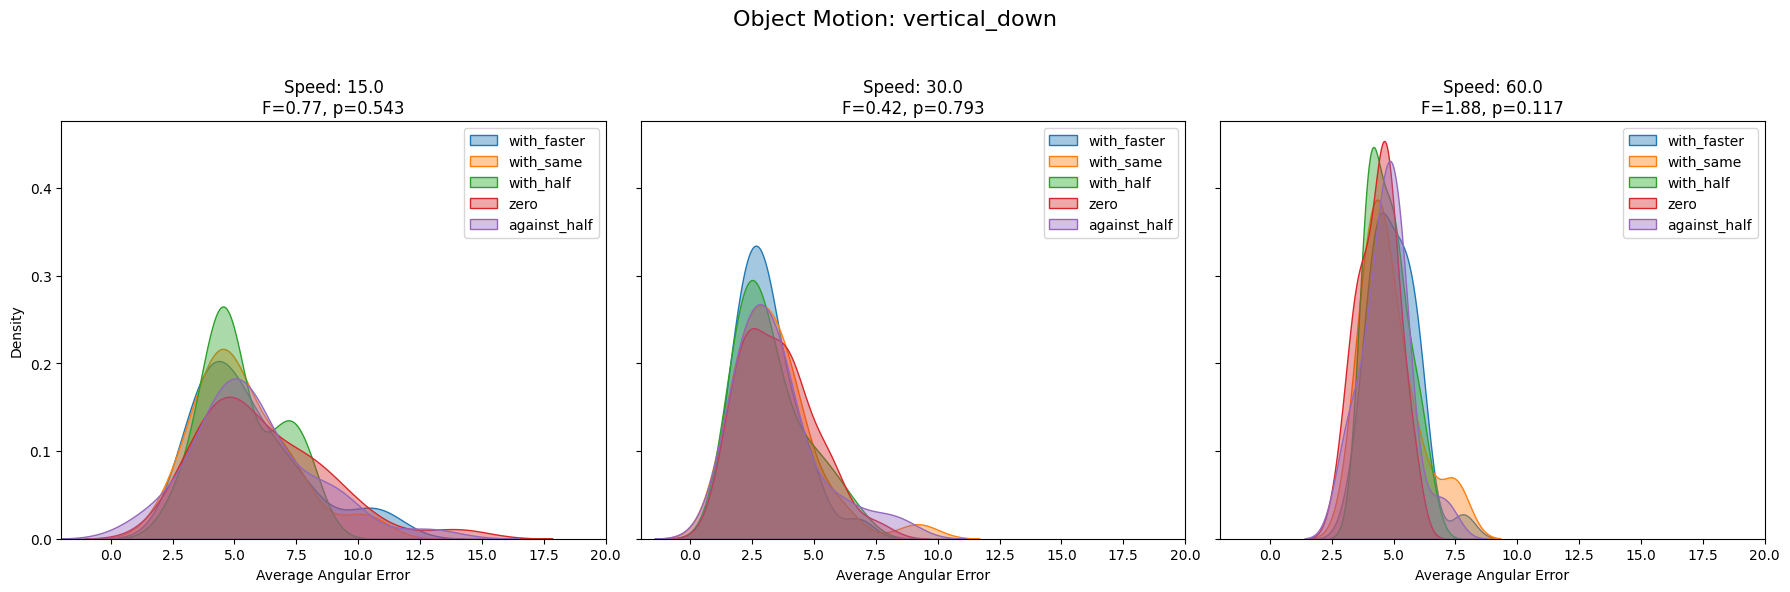

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns  # For smooth density plots
import os
def calculate_average_error_per_individual_trial(df, 
                                                 time_start=0, 
                                                 time_end=None, 
                                                 object_speed=None, 
                                                 object_motion_types=None):
    # Filter data based on time and validity
    filtered_df = df[(df['RelativeTime'] >= time_start) & 
                     (df['RelativeTime'] <= (time_end if time_end is not None else df['RelativeTime'].max()))]
    filtered_df = filtered_df[filtered_df['BestPogValid'] == True]

    # Filter based on object speed
    if object_speed is not None:
        filtered_df = filtered_df[filtered_df['object_speed'] == object_speed]

    # Adjust for direction for X-axis mappings
    if 'object_motion_type' in df.columns:
        filtered_df.loc[filtered_df['object_motion_type'] == 'horizontal_left', 'MappedPogX'] = -filtered_df['MappedPogX'] + screen_width
        filtered_df.loc[filtered_df['object_motion_type'] == 'horizontal_left', 'BallX'] = -filtered_df['BallX'] + screen_width

    # Filter based on object motion types
    if object_motion_types is not None and len(object_motion_types) != 0:
        filtered_df = filtered_df[filtered_df['object_motion_type'].isin(object_motion_types)]

    # Calculate the average angular error grouped by camera motion type and TrialID
    avg_error_per_individual_trial = filtered_df.groupby(
        ['camera_motion_type', 'TrialID', 'TrialNumber']
    )['AngularError'].mean().reset_index()
    # print(avg_error_per_individual_trial)
    return avg_error_per_individual_trial


def perform_anova_on_camera_motion_types(avg_error_per_individual_trial, camera_motion_types):
    # Filter data for the specified camera motion types
    avg_error_per_individual_trial = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'].isin(camera_motion_types)]
    
    # Organize the data by camera motion type for ANOVA
    error_data = [avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'] == motion_type]['AngularError'] 
                  for motion_type in camera_motion_types]
    
    if len(error_data) > 1:
        f_stat, p_value = f_oneway(*error_data)
        return {'F-statistic': f_stat, 'p-value': p_value}
    else:
        return {'F-statistic': None, 'p-value': None}  # Skip ANOVA if only one group


def analyze_camera_motion_types_for_object_velocity_combined(data, time_ranges, speeds, camera_motion_types, object_motion_types, name):
    # Create a figure with 3 subplots (one for each speed)
    fig, axes = plt.subplots(1, len(speeds), figsize=(18, 6), sharey=True)

    for idx, object_speed in enumerate(speeds):
        time_start, time_end = time_ranges.get(object_speed, (0, 4))  # Default time range if not specified

        # Calculate average angular error per individual trial
        avg_error_per_individual_trial = calculate_average_error_per_individual_trial(
            data, time_start, time_end, object_speed=object_speed, object_motion_types=object_motion_types
        )

        # Perform ANOVA for the given object velocity
        anova_results = perform_anova_on_camera_motion_types(avg_error_per_individual_trial, camera_motion_types)

        # Get the current subplot axis
        ax = axes[idx]

        # Shade the plot background gray if p-value is significant (p < 0.05)
        p_value = anova_results['p-value']
        if p_value is not None and p_value < 0.05:
            ax.set_facecolor('#f0f0f0')  # Light gray background for significant p-values

        # Plot a density plot of average angular error for each camera motion type
        for motion_type in camera_motion_types:
            motion_data = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'] == motion_type]
            sns.kdeplot(motion_data['AngularError'], label=f"{motion_type}", fill=True, alpha=0.4, ax=ax)

        # Display ANOVA results in the title
        f_stat = anova_results['F-statistic']
        ax.set_title(f"Speed: {object_speed}\nF={f_stat:.2f}, p={p_value:.3f}", fontsize=12)
        ax.set_xlabel("Average Angular Error")

        if idx == 0:  # Add y-axis label to the first subplot only
            ax.set_ylabel("Density")

        ax.legend()
        ax.set_xlim(-2, 20)

    # Set a global title and save the plot
    plt.suptitle(f"Object Motion: {object_motion_types[0]}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'Anovas/{name}/{object_motion_types[0]}_combined_anova_unfiltered.png')
    plt.show()


# Define parameters
time_ranges = {
    15.0: (0.0, 2.0),  
    30.0: (0.0, 2.0),
    60.0: (0.0, 2.0),  
}
object_speeds = [15.0, 30.0, 60.0]  # Specify the object velocity to analyze
names = [
    # 'jenna', 
    # 'tina', 
    # 'kenny', 
    # 'harsha', 
    # 'yunxiang', 
    # 'nick', 
    # 'jasmine', 
    'bingxuan'
    ]

for name in names:
    print(name)
    data = pd.read_csv(f'MainStudyFolder/gaze_data_main_{name}.csv', sep=',')
    trial_details_df = pd.read_csv("generated_trial_ids/generated_main_study_trial_ids.csv")

    if not os.path.exists(f"Anovas/{name}"):
        os.mkdir(f"Anovas/{name}")

    # Process data
    data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())
    data['MappedPogX'] = data['BestPogX'] * screen_width
    data['MappedPogY'] = screen_height - data['BestPogY'] * screen_height
    data[['BallX', 'BallY']] = data['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    data = data[(data['BallX'] >= 0) & (data['BallY'] >= 0)]
    data = map_camera_motion_type_and_object_speed(data, trial_details_df)

    # Smooth raw positional values for each trial
    data = apply_filter_per_trial(data, 'MappedPogX', 'FilteredPogX')
    data = apply_filter_per_trial(data, 'MappedPogY', 'FilteredPogY')

    screen_diagonal_size = 27.5  # inches
    distance_to_screen = 0.5842  # meters

    # Assuming df has been processed with compute_accuracy
    data = compute_position_dependent_angular_error(data, screen_width, screen_height, screen_diagonal_size, distance_to_screen)

    angular_error_threshold = 30.0  # Angular error threshold in degrees
    data = discard_trials_with_high_angular_error(data, angular_error_threshold)
    camera_motion_types = [
        'with_faster', 
        'with_same', 
        'with_half', 
        'zero', 
        'against_half'
        ]  # Camera motion types to compare
    object_motion_types = [
        ['horizontal_left', 'horizontal_right'],
        ['vertical_up'], 
        ['vertical_down']
    ]  # Specify motion types to filter

    for motion_types in object_motion_types:
        # Analyze the data for the given object velocity
        analyze_camera_motion_types_for_object_velocity_combined(data, time_ranges, object_speeds, camera_motion_types, motion_types, name)